In [1]:
cd(@__DIR__) #src
using Agents, Random
using Agents.DataFrames, Agents.Graphs
using Distributions: Poisson, DiscreteNonParametric
using DrWatson: @dict
using CairoMakie
CairoMakie.activate!() # hide
using InteractiveDynamics
using StatsBase
using ColorSchemes

In [6]:
function bit_2_int(arr)
    arr = reverse(arr)
    sum(((i, x),) -> Int(x) << ((i-1) * sizeof(x)), enumerate(arr.chunks))
end

#We initialize the model according to some parameters THAT ARE NOW HARDCODED BUT WILL NOT BE IN A NEAR FUTURE
function  model_init()
    @agent Cell GridAgent{2} begin
        time_alive::Int  # Time the cell has been alive
        near_cells::Int # Number of cells in the neighborhood
        genotype::BitArray # Genotype of the cell
    end

    seed = 0
    rng = MersenneTwister(seed)
    l=100
    n0=10
    ngenes=4
    space = GridSpace((l, l))
    properties=@dict()
    model = ABM(Cell, space;properties, rng) 

    for i in 1:n0
        #add_agent!(model,0,0,BitArray([false for x in 1:ngenes]))
        add_agent!((l/2,l/2),model,0,0,BitArray([false for x in 1:ngenes]))
    end
    return model
end

#Step evey agent, updating its parameters and then reproducing, moving and dying.
function agent_step!(agent, model)
    if agent.time_alive == 0
        mutate!(agent,model)
    end
    agent.time_alive += 1
    agent.near_cells = length(ids_in_position(agent, model))
    reproduce!(agent, model)
    move!(agent, model)
    die!(agent, model)
end

#Move every cell to a random nearby space ONLY if your space is "crowded", crowded for example is more than 1 cell in your space 
function move!(agent, model)
    pos = agent.pos
    nearby = [x for x in nearby_positions(agent,model,1)]
    newpos = rand(model.rng, nearby)
    if length(ids_in_position(agent, model)) > 1
        m = sample(nearby)
        move_agent!(agent,m, model)
    end
end

#reproduce, creating a new cell in the same space with a probability that decreases with how many cells are already in its space
function reproduce!(agent,model)
    fitness=Dict(0=>1,
                 1=>1.5,
                 2=>1.5,
                 3=>1.6,
                 4=>1.1,
                 5=>2,
                 6=>2,
                 7=>2,
                 8=>2,
                 9=>7,
                 10=>1.4,
                 11=>3,
                 12=>6,
                 13=>2,
                 14=>5,
                 15=>10)
    pr = 0.027*fitness[bit_2_int(agent.genotype)]
    pid = agent.pos
    newgenom = copy(agent.genotype)
    if rand(model.rng) < pr/(length(ids_in_position(agent, model))^2)
        add_agent!(pid,model,0,0,newgenom)
    end
end

#with a probability p choose a random non mutated gene and mutate it.
function mutate!(agent,model)
    mr = 0.01
    genes=findall(agent.genotype .!=1)
    if genes!=[] && rand(model.rng) < mr
        agent.genotype[rand(genes)]=true
    end
end

#die, with a probability that increases with the number of cells that are in its space.
function die!(agent, model)
    dr=0.01
    pos = agent.pos
    nearby = [x for x in nearby_positions(agent,model,1)]
    if rand(model.rng) < dr*(length(ids_in_position(agent, model))^2)
        kill_agent!(agent, model)
    end
end

function gen_function_genotype_fraction(ngenes)
    functions = []
    for i in 0:((2^ngenes)-1)
        compare = digits(i, base=2, pad=ngenes)
        func = function get_perc(x)
            len = length(findall([string(y)[5:end] for y in x] .== string(compare)))
            return len
        end
        push!(functions,func)
    end
    return functions
end

model = model_init()
println(model)
#we collect the number of cells that are alive
to_collect = [(:genotype, f) for f in gen_function_genotype_fraction(4)]
#push!(to_collect,(:time_alive, length))
#we run the simulation
data, _ = run!(model, agent_step!, 500; adata = to_collect)
ngenes=4
genotypes = [string(digits(i, base=2, pad=ngenes)) for i in 0:((2^ngenes)-1)]
pushfirst!(genotypes,"step")
rename!(data,genotypes)

AgentBasedModel with 10 agents of type Cell
 space: GridSpace with size (100, 100), metric=chebyshev, periodic=true
 scheduler: fastest
 properties: 


Row,step,"[0, 0, 0, 0]","[1, 0, 0, 0]","[0, 1, 0, 0]","[1, 1, 0, 0]","[0, 0, 1, 0]","[1, 0, 1, 0]","[0, 1, 1, 0]","[1, 1, 1, 0]","[0, 0, 0, 1]","[1, 0, 0, 1]","[0, 1, 0, 1]","[1, 1, 0, 1]","[0, 0, 1, 1]","[1, 0, 1, 1]","[0, 1, 1, 1]","[1, 1, 1, 1]"
,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64
1,0,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,3,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,4,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,5,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,6,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,7,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,8,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


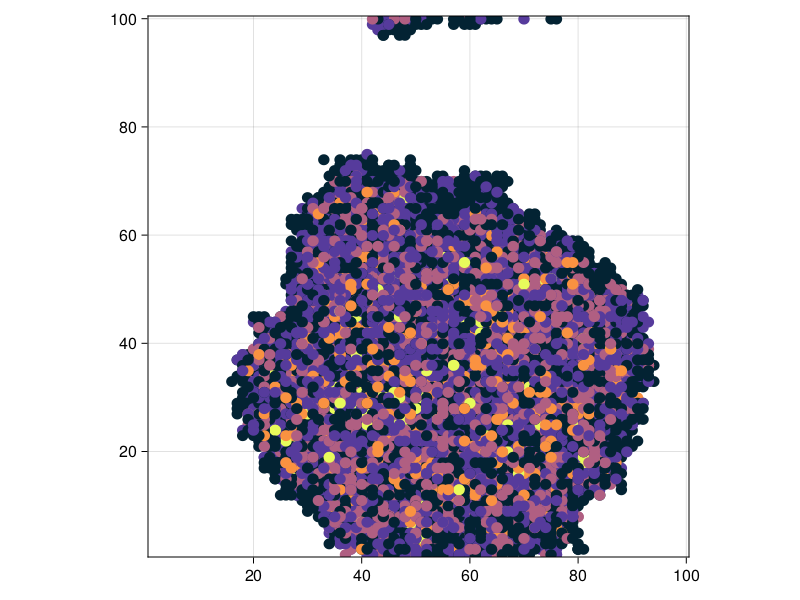

In [7]:

colors=Dict(0=>:black,1=>:red,2=>:blue,3=>:green,4=>:yellow,5=>:orange,6=>:purple,7=>:pink,8=>:brown,9=>:cyan,10=>:gray)
densitycolor(a) = get(colorschemes[:thermal], a.near_cells, (1,5))

figure, _ = abmplot(model;ac = densitycolor)
figure # returning the figure displays it

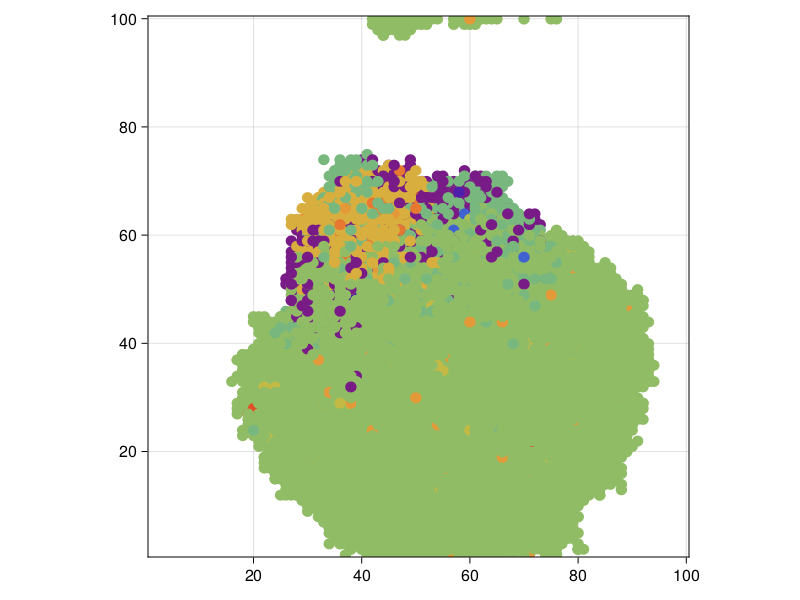

In [9]:

genotypecolor(a) = get(colorschemes[:rainbow], bit_2_int(a.genotype), (1,16))

figure, _ = abmplot(model;ac = genotypecolor)
figure # returning the figure displays it

0

In [10]:
model = model_init()
abmvideo(
    "animations/test_mut_11_11_22_2.mp4", model, agent_step!;
    framerate = 20, frames = 500,ac = densitycolor,
    title = "Tumor growth"
)

model = model_init()
abmvideo(
    "animations/test_gen_11_11_22_2.mp4", model, agent_step!;
    framerate = 20, frames = 500,ac = genotypecolor,
    title = "Tumor growth"
)

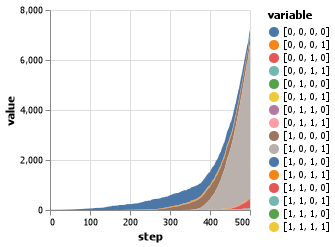

In [11]:
using VegaLite
using DataFrames
genotypes = [string(digits(i, base=2, pad=ngenes)) for i in 0:((2^ngenes)-1)]
stacked = stack(data,genotypes)

stacked |>
@vlplot(:area, x=:step, y={:value, stack=:zero}, color="variable:n")

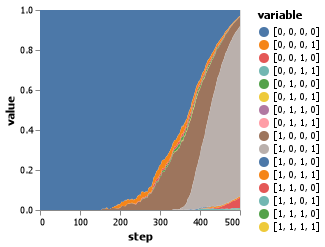

In [12]:
stacked |>
@vlplot(:area, x=:step, y={:value, stack=:normalize}, color="variable:n")